Hannah Lo, Henry Spinella, Kelsey Olesen


In [1]:
#importing libraries and data, examining data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

gov_df = pd.read_csv("data/governors_county_candidate.csv")
pres_df = pd.read_csv("data/president_county_candidate.csv")

nrows_gov, ncols_gov = gov_df.shape
nrow_pres, ncols_pres = pres_df.shape

print("# of rows in governor dataset:", nrows_gov)
print("# of columns:", ncols_gov)

print("# of rows in president dataset:", nrow_pres)
print("# of columns:", ncols_pres)

print(gov_df.columns.values)
print(pres_df.columns.values)

print(gov_df.dtypes)
print(pres_df.dtypes) #we did not have to change the data type of any of these columns

# of rows in governor dataset: 5145
# of columns: 6
# of rows in president dataset: 32177
# of columns: 6
['state' 'county' 'candidate' 'party' 'votes' 'won']
['state' 'county' 'candidate' 'party' 'total_votes' 'won']
state        object
county       object
candidate    object
party        object
votes         int64
won            bool
dtype: object
state          object
county         object
candidate      object
party          object
total_votes     int64
won              bool
dtype: object


In [2]:
#cleaning data where no one wrote in a candidate even though they selected Write-In aka blank ballots
#dont want to include this in our analysis because it doesn't help us understand any differences
clean_gov_df = gov_df.query("candidate != ' Write-ins' | votes != 0")
clean_pres_df = pres_df.query("candidate != ' Write-ins' | total_votes != 0").copy() #python threw an error  during renaming when i didn't make this an explicit copy

#also renaming clean_pres column total_votes into votes for ease of understanding

clean_pres_df.rename(columns={'total_votes' : 'votes'}, inplace=True)
clean_pres_df.columns



Index(['state', 'county', 'candidate', 'party', 'votes', 'won'], dtype='object')

Merging and Aggregating

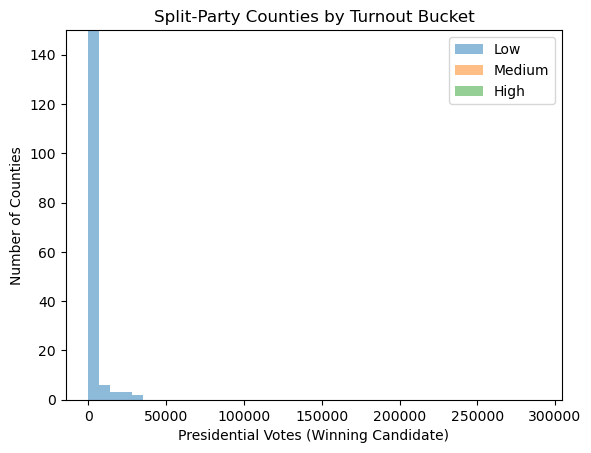

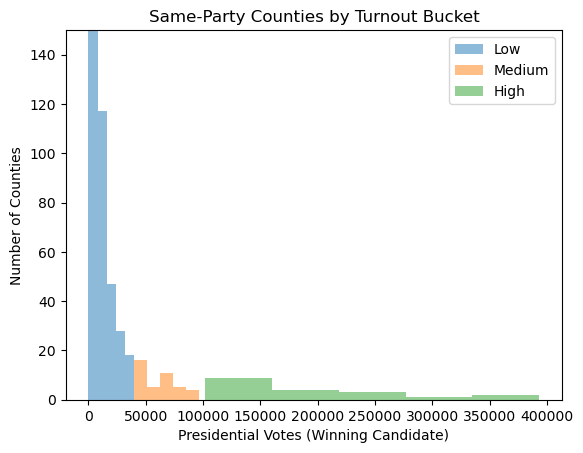

In [ ]:
gov_by_county = clean_gov_df.groupby(['state', 'county'], as_index=False)['votes'].sum()
pres_by_county = clean_pres_df.groupby(['state', 'county'], as_index=False)['votes'].sum() #grouping the data makes state and county indexes unless we use as_index = false

gov_winners = clean_gov_df[clean_gov_df['won']].copy()
pres_winners = clean_pres_df[clean_pres_df['won']].copy()

merged_data = gov_winners.merge(
    pres_winners,
    on=['state', 'county'],
    suffixes=('_gov', '_pres')
)

merged_data['party_eq'] = merged_data['party_gov'] == merged_data['party_pres']


bins = [0, 40000, 100000, 900000]
labels = ['Low', 'Medium', 'High']

merged_data['vote_bucket'] = pd.cut(
    merged_data['votes_pres'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

split = merged_data[merged_data['party_eq'] == False]


for bucket in labels:
    subset = split[split['vote_bucket'] == bucket]

    plt.hist(
        subset['votes_pres'],
        bins=5,
        alpha=0.5,
        label= bucket
    )
plt.xlabel("Presidential Votes (Winning Candidate)")
plt.ylabel("Number of Counties")
plt.title("Split-Party Counties by Turnout Bucket")
plt.ylim(0, 150)  
plt.legend()
plt.show()

same = merged_data[merged_data['party_eq'] == True]
for bucket in labels:
    subset = same[same['vote_bucket'] == bucket]

    plt.hist(
        subset['votes_pres'],
        bins=5,
        alpha=0.5,
        label=bucket
    )

plt.xlabel("Presidential Votes (Winning Candidate)")
plt.ylabel("Number of Counties")
plt.title("Same-Party Counties by Turnout Bucket")
plt.ylim(0, 150)  
plt.legend()
plt.show()

#more less populated counties in the split-party subset compared to the same-party

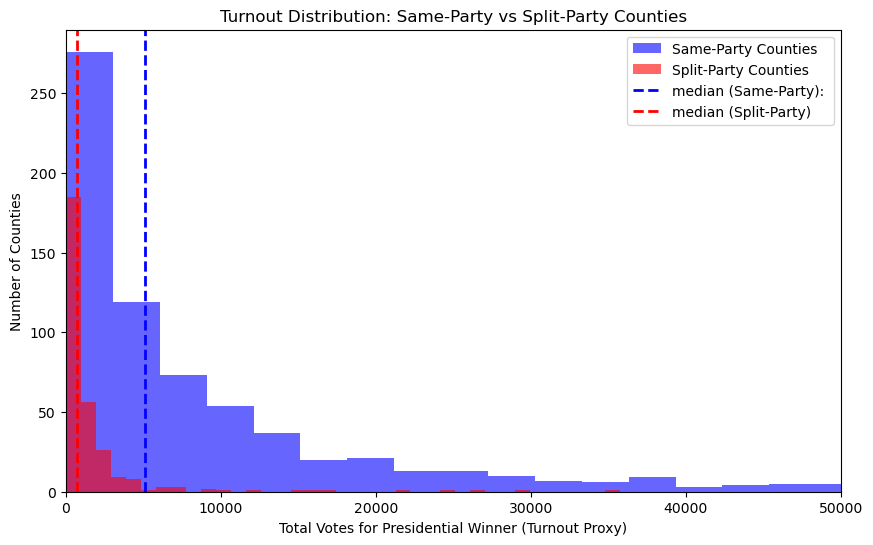

In [24]:
# Aggregate votes by county
gov_by_county = clean_gov_df.groupby(['state', 'county'], as_index=False)['votes'].sum()
pres_by_county = clean_pres_df.groupby(['state', 'county'], as_index=False)['votes'].sum()

# Winners only
gov_winners = clean_gov_df[clean_gov_df['won']].copy()
pres_winners = clean_pres_df[clean_pres_df['won']].copy()

# Merge results
merged_data = gov_winners.merge(
    pres_winners,
    on=['state', 'county'],
    suffixes=('_gov', '_pres')
)

# True = same-party; False = split-party
merged_data['party_eq'] = merged_data['party_gov'] == merged_data['party_pres']


merged_data['vote_bucket'] = pd.cut(
    merged_data['votes_pres'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Split and same subsets
split = merged_data[merged_data['party_eq'] == False]
same  = merged_data[merged_data['party_eq'] == True]

# Calculate medians
same_median  = same['votes_pres'].median()
split_median = split['votes_pres'].median()


# Plot histograms together
plt.figure(figsize=(10, 6))

plt.hist(
    same['votes_pres'],
    bins=300,
    alpha=0.6,
    label='Same-Party Counties',
    color='blue'
)

plt.hist(
    split['votes_pres'],
    bins=300,
    alpha=0.6,
    label='Split-Party Counties',
    color='red'
)

plt.axvline(same_median,  color='blue', linestyle='--', linewidth=2,
            label=f"median (Same-Party): ")

plt.axvline(split_median, color='red',  linestyle='--', linewidth=2,
            label=f"median (Split-Party)")

plt.xlabel("Total Votes for Presidential Winner (Turnout Proxy)")
plt.ylabel("Number of Counties")
plt.title("Turnout Distribution: Same-Party vs Split-Party Counties")
# STRICT RANGE
plt.xlim(0, 50000)
plt.legend()
plt.show()

In each county, how strongly is the governor’s winning vote share correlated with the president’s winning vote share?

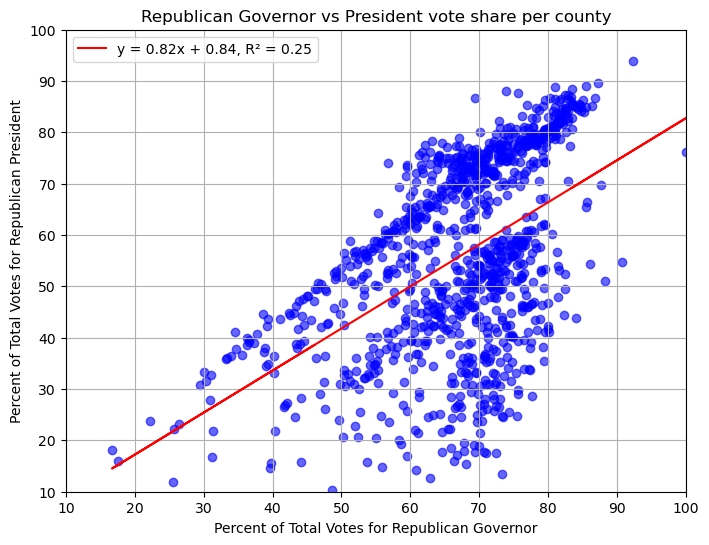

In [ ]:
import matplotlib.pyplot as plt

# Sum Republican votes per county
gov_R_votes = clean_gov_df[clean_gov_df['party'] == 'REP'].groupby(['state','county'], as_index=False)['votes'].sum()
pres_R_votes = clean_pres_df[clean_pres_df['party'] == 'REP'].groupby(['state','county'], as_index=False)['votes'].sum()

# Merge Republican votes and total votes per county
merged_votes = gov_by_county.rename(columns={'votes':'gov_total_votes'}).merge(
    gov_R_votes.rename(columns={'votes':'gov_R_votes'}),
    on=['state','county']
).merge(
    pres_by_county.rename(columns={'votes':'pres_total_votes'}),
    on=['state','county']
).merge(
    pres_R_votes.rename(columns={'votes':'pres_R_votes'}),
    on=['state','county']
)

# Compute true Republican vote share
merged_votes['gov_R_share'] = merged_votes['gov_R_votes'] / merged_votes['gov_total_votes']
merged_votes['pres_R_share'] = merged_votes['pres_R_votes'] / merged_votes['pres_total_votes']

# Scatter plot: each point = one county
x = merged_votes['gov_R_share']*100
y = merged_votes['pres_R_share']*100
plt.figure(figsize=(8,6))
plt.scatter(
    x,
    y,
    alpha=0.6,
    color='blue'
)

# Fit linear regression
slope, intercept = np.polyfit(x, y, 1)
line_y = slope * x + intercept

# Calculate R^2
correlation_matrix = np.corrcoef(x, y)
r_value = correlation_matrix[0,1]
r_squared = r_value**2

# Plot line with equation and R^2 in legend
plt.plot(x, line_y, color='red', label=f'y = {slope:.2f}x + {intercept:.2f}, R² = {r_squared:.2f}')

# Set axes range from 10 to 100
plt.xlim(10, 100)
plt.ylim(10, 100)

# Labels and title
plt.xlabel("Percent of Total Votes for Republican Governor")
plt.ylabel("Percent of Total Votes for Republican President")
plt.title("Republican Governor vs President vote share per county")
plt.grid(True)

plt.legend()
plt.show()


Descriptive Statistics

In [27]:
desc_stats = merged_votes[['gov_total_votes','gov_R_votes','pres_total_votes','pres_R_votes',]].describe()
display(desc_stats)

,gov_total_votes,gov_R_votes,pres_total_votes,pres_R_votes
count,1.025000e+03,1025.000000,1.025000e+03,1025.000000
mean,1.992216e+04,10437.711220,2.009558e+04,10205.553171
std,6.505975e+04,25767.930968,6.559663e+04,24576.412354
min,5.000000e+00,4.000000,5.000000e+00,0.000000
25%,1.089000e+03,739.000000,1.109000e+03,468.000000
50%,3.778000e+03,2623.000000,3.844000e+03,2199.000000
75%,1.323000e+04,8487.000000,1.341400e+04,8725.000000
max,1.198049e+06,307022.000000,1.210507e+06,269167.000000


<h2 style="color: darkblue;">2020 U.S. Election Results Analysis</h2>

From the 2020 U.S. election results, we observe that the **median voter turnout is lower in split-ticket counties**, where voters elected governors and presidents from different parties. However, this pattern is **heavily skewed by a few high-turnout, same-party counties**, which raise the overall average. Additionally, our analysis shows a **weak correlation between the percentage of votes for Republican candidates in presidential vs. governor races at the county level**, indicating that counties that elect a majority for one party in the presidential race are somewhat more likely to elect a governor from the same party. A **slope of 0.82** indicates that the governor's share of votes affects the presidential party winner **less than vice versa**, meaning presidential outcomes are slightly more predictive of governor results than the other way around. Nonetheless, the **R² value of only 0.25** suggests that this relationship is relatively weak and other factors likely influence voting patterns across counties.

